In [1]:
import pandas as pd
import psycopg2
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt
from datetime import timedelta

# Connect to PostgreSQL and load data
try:
    conn = psycopg2.connect(dbname="CryptoMarket", user="postgres", password="SYS", host="localhost")
    cur = conn.cursor()
    cur.execute("SELECT coin, price_date, price FROM historical_prices ORDER BY coin, price_date;")
    rows = cur.fetchall()
    df = pd.DataFrame(rows, columns=['coin', 'ds', 'y'])
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = pd.to_numeric(df['y'])
    print("Data loaded successfully. Shape:", df.shape)
    if df.empty:
        raise ValueError("DataFrame is empty. Check PostgreSQL table 'historical_prices'.")

except psycopg2.Error as e:
    print(f"Database Error: {e}")
    raise
except ValueError as e:
    print(f"Data Error: {e}")
    raise

finally:
    if conn:
        cur.close()
        conn.close()

Data loaded successfully. Shape: (7130, 3)


Data Summary:
                                  ds              y
count                           7130    7130.000000
mean   2024-12-13 07:47:32.734922752    8876.317361
min              2024-06-12 00:00:00       0.083770
25%              2024-09-13 00:00:00       0.999508
50%              2024-12-15 00:00:00      15.199125
75%              2025-03-14 00:00:00    1793.292644
max              2025-06-11 00:00:00  111560.356938
std                              NaN   25230.848642

Missing Values:
coin    0
ds      0
y       0
dtype: int64

Coins and Data Points:
coin
avalanche-2        365
binancecoin        365
wrapped-bitcoin    365
usd-coin           365
tron               365
tether             365
sui                365
stellar            365
staked-ether       365
solana             365
ripple             365
leo-token          365
ethereum           365
dogecoin           365
chainlink          365
cardano            365
bitcoin-cash       365
bitcoin            365
wrapped-steth  

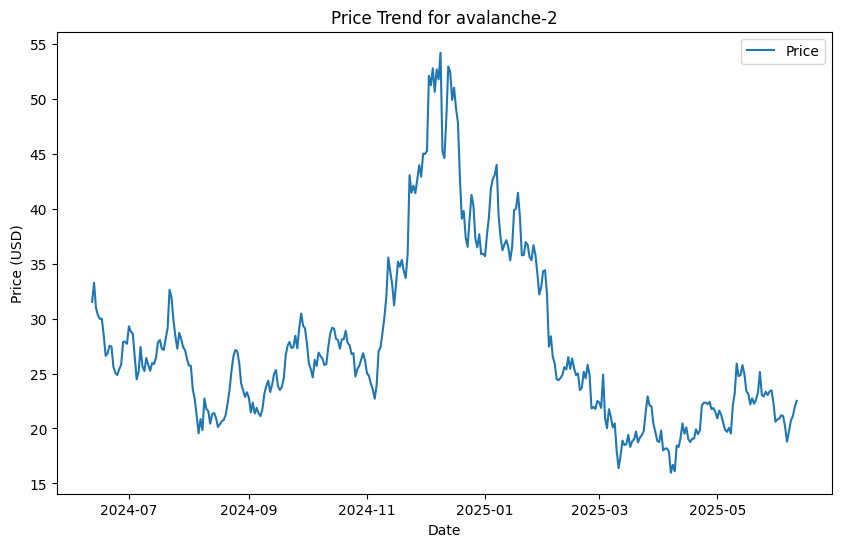

In [2]:
# EDA
print("Data Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nCoins and Data Points:")
print(df['coin'].value_counts())

# Plot sample data for one coin to verify
sample_coin = df[df['coin'] == df['coin'].unique()[0]]  # First coin
if len(sample_coin) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(sample_coin['ds'], sample_coin['y'], label='Price')
    plt.title(f'Price Trend for {sample_coin["coin"].iloc[0]}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()
else:
    print("No data available for the first coin. Check coin uniqueness.")

In [3]:
# Feature Engineering
df = df.sort_values(['coin', 'ds'])
df['y_lag1'] = df.groupby('coin')['y'].shift(1)  # 1-day lag
df['y_rolling_mean7'] = df.groupby('coin')['y'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df = df.dropna()  # Remove NaN from lagged features

# Split by coin, keeping only necessary columns
coin_dfs = {coin: group[['ds', 'y', 'y_lag1', 'y_rolling_mean7']].copy() for coin, group in df.groupby('coin')}

# Verify feature engineering
for coin_id, coin_df in coin_dfs.items():
    if coin_df.empty or coin_df.isnull().any().any():
        print(f"Warning: Empty or NaN data for {coin_id}. Skipping this coin.")
        del coin_dfs[coin_id]
    else:
        print(f"Verified data for {coin_id}. Shape: {coin_df.shape}")

print("Sample of engineered data for first coin:")
print(coin_dfs[df['coin'].unique()[0]].head())

Verified data for avalanche-2. Shape: (364, 4)
Verified data for binancecoin. Shape: (364, 4)
Verified data for bitcoin. Shape: (364, 4)
Verified data for bitcoin-cash. Shape: (364, 4)
Verified data for cardano. Shape: (364, 4)
Verified data for chainlink. Shape: (364, 4)
Verified data for dogecoin. Shape: (364, 4)
Verified data for ethereum. Shape: (364, 4)
Verified data for hyperliquid. Shape: (194, 4)
Verified data for leo-token. Shape: (364, 4)
Verified data for ripple. Shape: (364, 4)
Verified data for solana. Shape: (364, 4)
Verified data for staked-ether. Shape: (364, 4)
Verified data for stellar. Shape: (364, 4)
Verified data for sui. Shape: (364, 4)
Verified data for tether. Shape: (364, 4)
Verified data for tron. Shape: (364, 4)
Verified data for usd-coin. Shape: (364, 4)
Verified data for wrapped-bitcoin. Shape: (364, 4)
Verified data for wrapped-steth. Shape: (364, 4)
Sample of engineered data for first coin:
          ds          y     y_lag1  y_rolling_mean7
1 2024-06-13 

In [14]:
# Model Training and Prediction for 12 months (365 days)
for coin_id, coin_df in coin_dfs.items():
    print(f"Training model for {coin_id}...")
    model = NeuralProphet(
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        learning_rate=0.1,
        n_changepoints=50
    )
    model.add_lagged_regressor(names='y_lag1')
    model.add_lagged_regressor(names='y_rolling_mean7')

    # Fit the model with all required columns
    metrics = model.fit(coin_df, freq='D')
    print(f"Model metrics for {coin_id}: {metrics}")

    # Get the last historical date
    last_historical_date = coin_df['ds'].max()
    print(f"Last historical date for {coin_id}: {last_historical_date}")

    # Create future dataframe starting right after the last historical date
    future_dates = pd.date_range(start=last_historical_date + timedelta(days=1), periods=365, freq='D')
    # For future prediction, only 'ds' and regressor columns are needed (no 'y')
    last_y_lag1 = coin_df['y_lag1'].iloc[-1]
    last_y_rolling_mean7 = coin_df['y_rolling_mean7'].iloc[-1]
    future_df = pd.DataFrame({
        'ds': future_dates,
        'y_lag1': last_y_lag1,
        'y_rolling_mean7': last_y_rolling_mean7
    })

    # Predict future prices only
    forecast_future = model.predict(future_df)

    # Verify future dates
    if forecast_future.empty:
        print(f"Warning: No future predictions for {coin_id}. Check model or data.")
    else:
        print(f"Forecast date range for {coin_id}: {forecast_future['ds'].min()} to {forecast_future['ds'].max()}")

    # Plot forecast, showing only future predictions with historical context
    plt.figure(figsize=(12, 6))
    # Plot historical actuals if 'y' exists
    if 'y' in coin_df.columns:
        plt.plot(coin_df['ds'], coin_df['y'], label='Historical Price', alpha=0.5, color='blue')
    # Plot predicted values for historical period if available
    if 'forecast_historical' in locals() and not forecast_historical.empty and 'yhat1' in forecast_historical.columns:
        plt.plot(forecast_historical['ds'], forecast_historical['yhat1'], label='Fitted (Historical)', color='green', linestyle='-')
    # Plot predicted values for future period
    if not forecast_future.empty and 'yhat1' in forecast_future.columns:
        plt.plot(forecast_future['ds'], forecast_future['yhat1'], label='Predicted Price', color='orange', linestyle='--')
    plt.axvline(x=last_historical_date, color='red', linestyle=':', label='End of Historical Data')
    plt.title(f'Price Prediction for {coin_id} (Next 12 Months)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Save forecast
    forecast_future.to_csv(f'forecast_{coin_id}_12months.csv', index=False)

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for avalanche-2...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for avalanche-2:      train_loss  reg_loss        MAE       RMSE      Loss  RegLoss  epoch
0      0.979954       0.0  40.528629  48.491146  0.973879      0.0      0
1      0.390726       0.0  18.996866  23.588840  0.387998      0.0      1
2      0.134719       0.0   8.773083  11.459314  0.134201      0.0      2
3      0.061912       0.0   5.205808   6.883267  0.061431      0.0      3
4      0.028009       0.0   3.370839   4.398407  0.027703      0.0      4
..          ...       ...        ...        ...       ...      ...    ...
155    0.004214       0.0   1.267993   1.626758  0.004289      0.0    155
156    0.004191       0.0   1.254919   1.603810  0.004172      0.0    156
157    0.004186       0.0   1.254212   1.611854  0.004163      0.0    157
158    0.004212       0.0   1.259088   1.601756  0.004183      0.0    158
159    0.004182       0.0   1.252987   1.609697  0.004151      0.0    159

[160 rows x 7 columns]
Last historical date for avalanche-2: 2025-06-11 00:00:00

KeyError: 'y'

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for avalanche-2...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for avalanche-2:      train_loss  reg_loss        MAE       RMSE      Loss  RegLoss  epoch
0      1.405496       0.0  57.081665  67.252663  1.407006      0.0      0
1      0.831551       0.0  36.438778  41.750210  0.828452      0.0      1
2      0.326541       0.0  17.754284  20.944704  0.325610      0.0      2
3      0.177218       0.0   9.842517  13.180892  0.178752      0.0      3
4      0.147250       0.0   8.076889  11.010884  0.146811      0.0      4
..          ...       ...        ...        ...       ...      ...    ...
155    0.004423       0.0   1.289940   1.662641  0.004471      0.0    155
156    0.004437       0.0   1.287992   1.667535  0.004421      0.0    156
157    0.004407       0.0   1.288554   1.654517  0.004396      0.0    157
158    0.004411       0.0   1.287700   1.655573  0.004396      0.0    158
159    0.004446       0.0   1.299531   1.672249  0.004463      0.0    159

[160 rows x 7 columns]
Last historical date for avalanche-2: 2025-06-11 00:00:00

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for avalanche-2: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


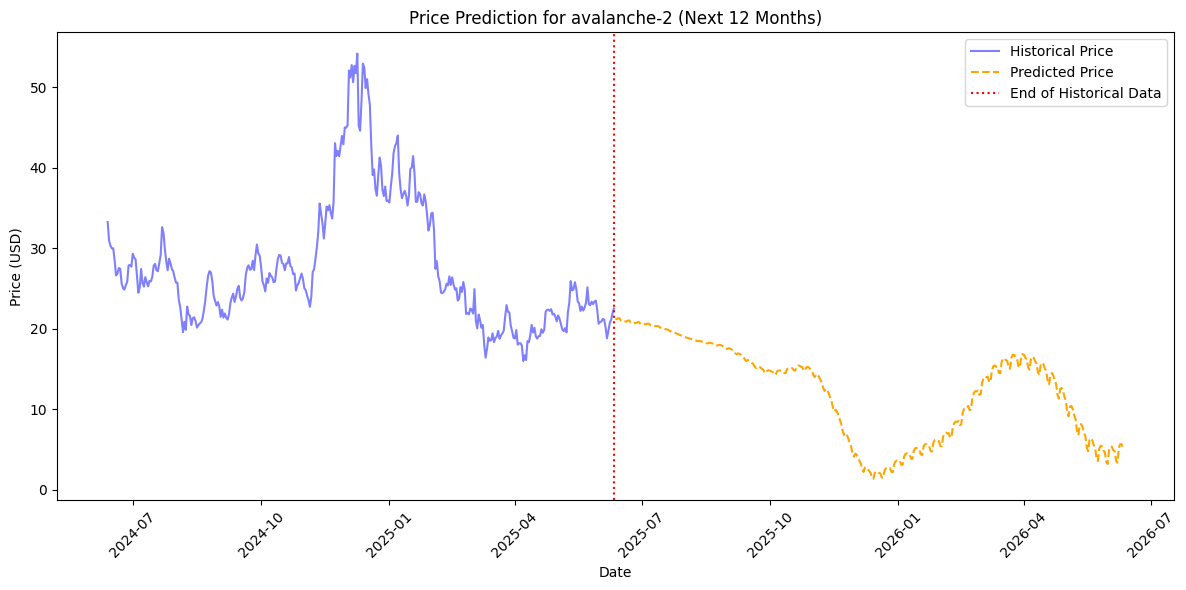

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for binancecoin...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for binancecoin:      train_loss  reg_loss         MAE        RMSE      Loss  RegLoss  epoch
0      1.234640       0.0  409.640930  476.023621  1.228879      0.0      0
1      0.611925       0.0  218.791397  246.331100  0.606964      0.0      1
2      0.221476       0.0   99.671227  117.446915  0.222288      0.0      2
3      0.280400       0.0  123.888290  148.005112  0.280230      0.0      3
4      0.187169       0.0   94.065018  113.489250  0.185949      0.0      4
..          ...       ...         ...         ...       ...      ...    ...
155    0.007197       0.0   14.201575   18.007462  0.007145      0.0    155
156    0.007185       0.0   14.179741   17.845760  0.007108      0.0    156
157    0.007154       0.0   14.190856   18.319653  0.007165      0.0    157
158    0.007174       0.0   14.168918   17.912918  0.007126      0.0    158
159    0.007140       0.0   14.154728   18.039499  0.007110      0.0    159

[160 rows x 7 columns]
Last historical date for binancec

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for binancecoin: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


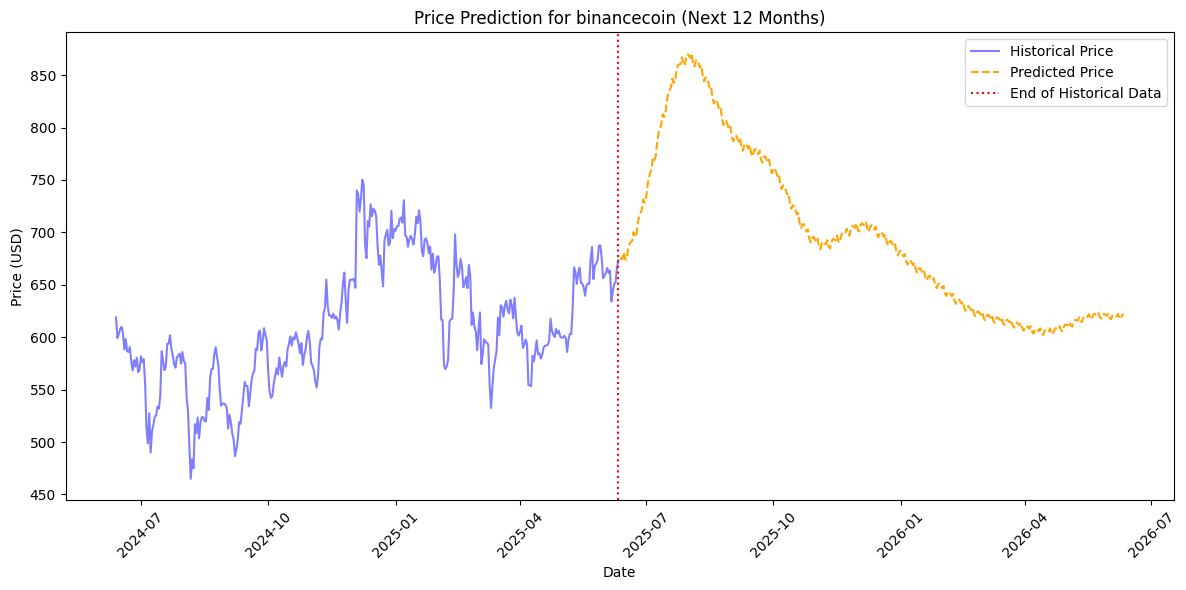

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for bitcoin...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for bitcoin:      train_loss  reg_loss           MAE          RMSE      Loss  RegLoss  \
0      0.136496       0.0  16993.417969  22684.019531  0.136176      0.0   
1      0.060396       0.0   9905.644531  13845.710938  0.059978      0.0   
2      0.024111       0.0   5609.398926   7790.461914  0.023975      0.0   
3      0.010496       0.0   3748.131348   4875.626465  0.010428      0.0   
4      0.006802       0.0   3026.932373   3827.703369  0.006795      0.0   
..          ...       ...           ...           ...       ...      ...   
155    0.002618       0.0   1803.011719   2274.223389  0.002611      0.0   
156    0.002602       0.0   1799.720459   2270.416016  0.002589      0.0   
157    0.002622       0.0   1806.832520   2285.936279  0.002629      0.0   
158    0.002644       0.0   1816.221436   2279.336670  0.002627      0.0   
159    0.002624       0.0   1814.968018   2259.511719  0.002613      0.0   

     epoch  
0        0  
1        1  
2        2  
3       

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for bitcoin: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


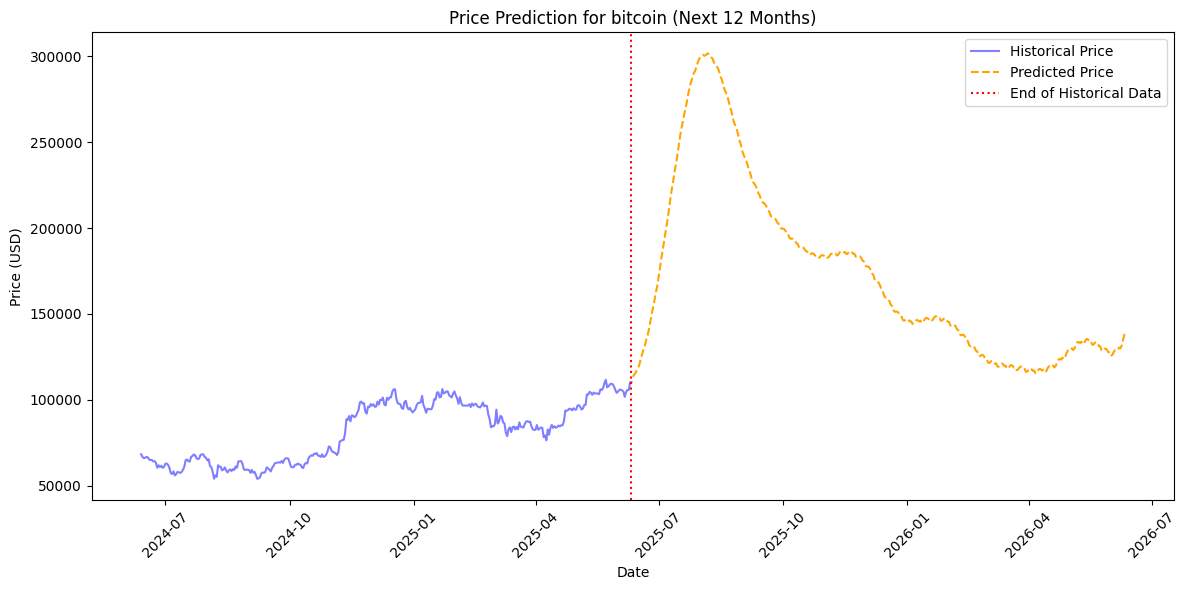

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for bitcoin-cash...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for bitcoin-cash:      train_loss  reg_loss         MAE        RMSE      Loss  RegLoss  epoch
0      0.599169       0.0  235.535477  282.208679  0.596977      0.0      0
1      0.358819       0.0  151.382172  185.977600  0.357918      0.0      1
2      0.187418       0.0   96.226646  119.385803  0.186121      0.0      2
3      0.088786       0.0   60.417431   81.669731  0.087784      0.0      3
4      0.066602       0.0   51.776951   67.240929  0.066150      0.0      4
..          ...       ...         ...         ...       ...      ...    ...
155    0.006348       0.0   13.615923   17.551086  0.006463      0.0    155
156    0.006329       0.0   13.512818   17.413759  0.006375      0.0    156
157    0.006377       0.0   13.569084   17.465021  0.006491      0.0    157
158    0.006331       0.0   13.558203   17.551029  0.006336      0.0    158
159    0.006338       0.0   13.664392   17.579527  0.006457      0.0    159

[160 rows x 7 columns]
Last historical date for bitcoin

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for bitcoin-cash: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


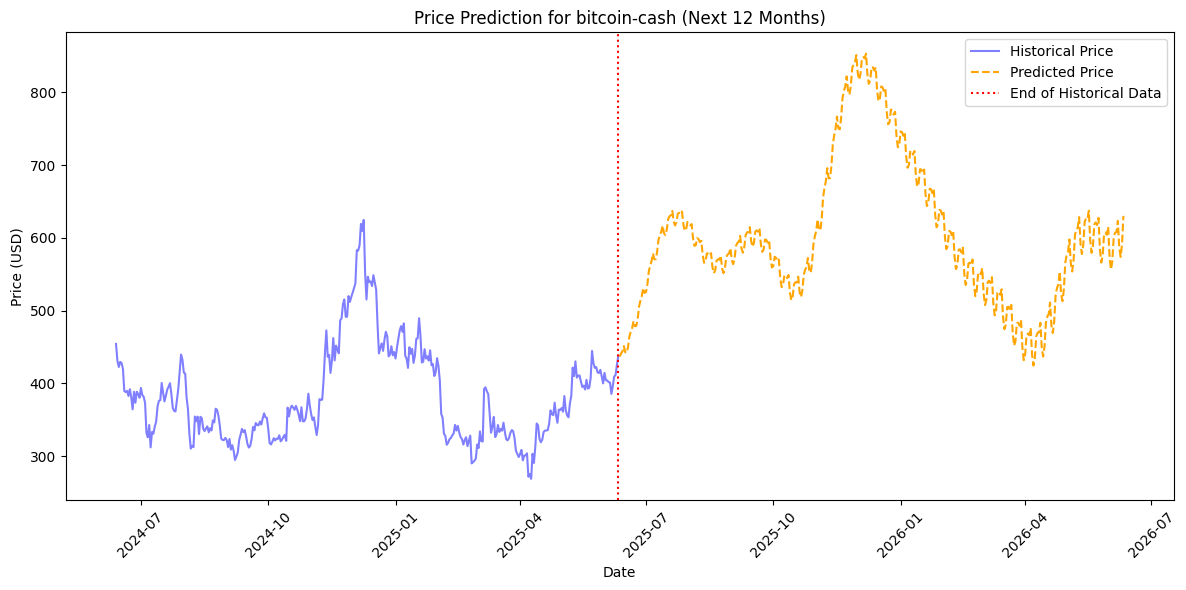

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for cardano...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for cardano:      train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
0      0.493802       0.0  0.587629  0.714795  0.491143      0.0      0
1      0.197213       0.0  0.308968  0.382618  0.197359      0.0      1
2      0.091336       0.0  0.188400  0.232060  0.090884      0.0      2
3      0.065236       0.0  0.147556  0.184372  0.064964      0.0      3
4      0.044930       0.0  0.113902  0.147114  0.044557      0.0      4
..          ...       ...       ...       ...       ...      ...    ...
155    0.004709       0.0  0.029134  0.042439  0.004662      0.0    155
156    0.004689       0.0  0.028921  0.042014  0.004645      0.0    156
157    0.004711       0.0  0.028884  0.041988  0.004681      0.0    157
158    0.004689       0.0  0.028755  0.041270  0.004640      0.0    158
159    0.004708       0.0  0.028983  0.042162  0.004675      0.0    159

[160 rows x 7 columns]
Last historical date for cardano: 2025-06-11 00:00:00
Combined dataframe columns for 

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for cardano: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


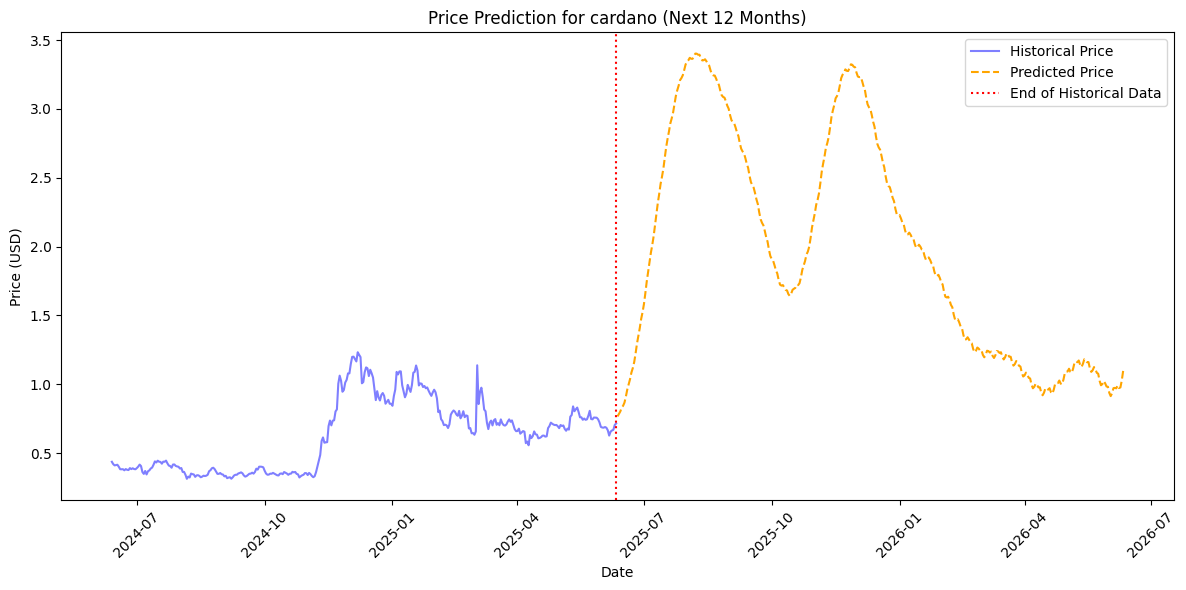

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for chainlink...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for chainlink:      train_loss  reg_loss        MAE       RMSE      Loss  RegLoss  epoch
0      1.530072       0.0  31.395737  35.731789  1.525441      0.0      0
1      0.941127       0.0  20.722645  22.965748  0.939324      0.0      1
2      0.431961       0.0  10.938013  12.179163  0.428480      0.0      2
3      0.119598       0.0   4.088740   5.251605  0.119587      0.0      3
4      0.142371       0.0   4.445517   5.650170  0.141401      0.0      4
..          ...       ...        ...        ...       ...      ...    ...
155    0.005475       0.0   0.730651   0.963499  0.005466      0.0    155
156    0.005472       0.0   0.734393   0.980409  0.005509      0.0    156
157    0.005484       0.0   0.730578   0.967853  0.005476      0.0    157
158    0.005492       0.0   0.732560   0.984495  0.005469      0.0    158
159    0.005478       0.0   0.734209   0.974859  0.005478      0.0    159

[160 rows x 7 columns]
Last historical date for chainlink: 2025-06-11 00:00:00
Com

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for chainlink: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


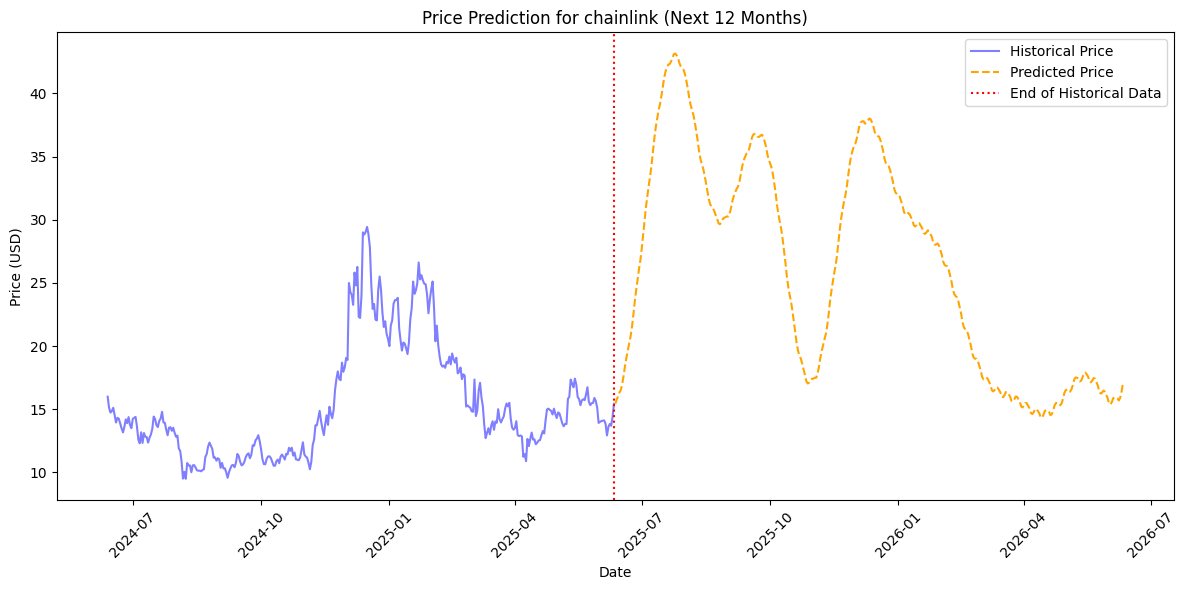

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for dogecoin...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for dogecoin:      train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
0      1.283994       0.0  0.546338  0.635936  1.282689      0.0      0
1      0.753833       0.0  0.345223  0.395917  0.750643      0.0      1
2      0.286716       0.0  0.155590  0.190421  0.285161      0.0      2
3      0.134934       0.0  0.085594  0.112682  0.135853      0.0      3
4      0.107763       0.0  0.078448  0.098189  0.107278      0.0      4
..          ...       ...       ...       ...       ...      ...    ...
155    0.002781       0.0  0.009889  0.013985  0.002767      0.0    155
156    0.002778       0.0  0.010030  0.013774  0.002808      0.0    156
157    0.002777       0.0  0.010063  0.013928  0.002886      0.0    157
158    0.002771       0.0  0.009998  0.014088  0.002804      0.0    158
159    0.002782       0.0  0.009998  0.014102  0.002778      0.0    159

[160 rows x 7 columns]
Last historical date for dogecoin: 2025-06-11 00:00:00
Combined dataframe columns fo

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for dogecoin: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


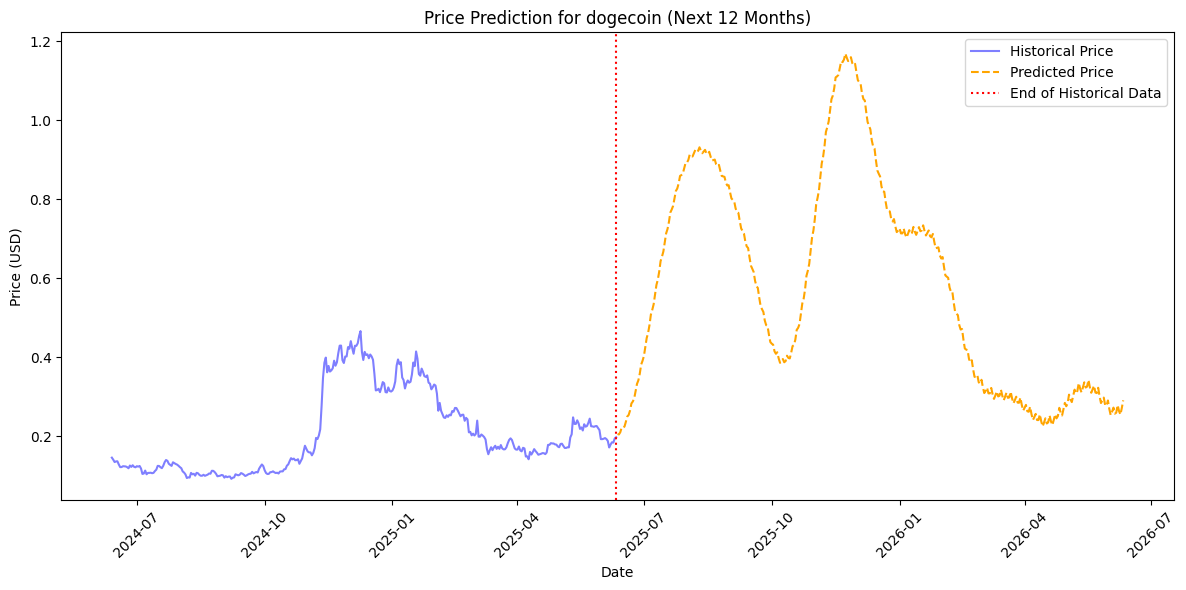

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for ethereum...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for ethereum:      train_loss  reg_loss          MAE         RMSE      Loss  RegLoss  epoch
0      1.191280       0.0  3743.967285  4501.208008  1.187273      0.0      0
1      0.573556       0.0  2035.264038  2519.878662  0.568496      0.0      1
2      0.169862       0.0   830.727661  1144.505005  0.169659      0.0      2
3      0.129349       0.0   634.421631   780.402710  0.128023      0.0      3
4      0.058478       0.0   400.152679   508.964539  0.058933      0.0      4
..          ...       ...          ...          ...       ...      ...    ...
155    0.003560       0.0    90.383949   114.649147  0.003571      0.0    155
156    0.003568       0.0    90.114059   113.693871  0.003548      0.0    156
157    0.003556       0.0    90.322639   114.352425  0.003572      0.0    157
158    0.003565       0.0    91.124260   115.160934  0.003649      0.0    158
159    0.003580       0.0    90.220291   113.075142  0.003572      0.0    159

[160 rows x 7 columns]
Last histori

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for ethereum: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


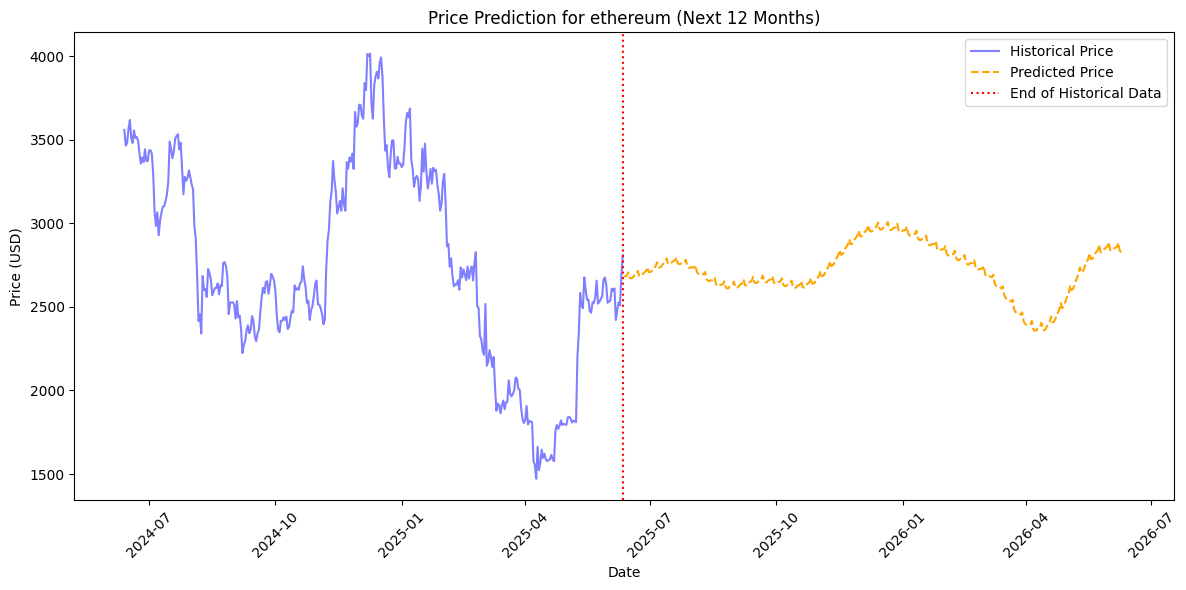

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.485% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for hyperliquid...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for hyperliquid:      train_loss  reg_loss        MAE       RMSE      Loss  RegLoss  epoch
0      0.307800       0.0  19.052662  24.202496  0.334013      0.0      0
1      0.123747       0.0   8.590475  12.156936  0.116258      0.0      1
2      0.087795       0.0   6.513767   8.373292  0.085164      0.0      2
3      0.055967       0.0   4.601250   6.083051  0.051933      0.0      3
4      0.043524       0.0   4.766964   6.079364  0.048073      0.0      4
..          ...       ...        ...        ...       ...      ...    ...
185    0.015573       0.0   2.566173   3.214691  0.014813      0.0    185
186    0.015295       0.0   2.357832   3.025364  0.014193      0.0    186
187    0.014817       0.0   2.480699   3.164023  0.014487      0.0    187
188    0.014671       0.0   2.608700   3.238319  0.015568      0.0    188
189    0.014759       0.0   2.516029   3.156136  0.014163      0.0    189

[190 rows x 7 columns]
Last historical date for hyperliquid: 2025-06-11 00:00:00

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for hyperliquid: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


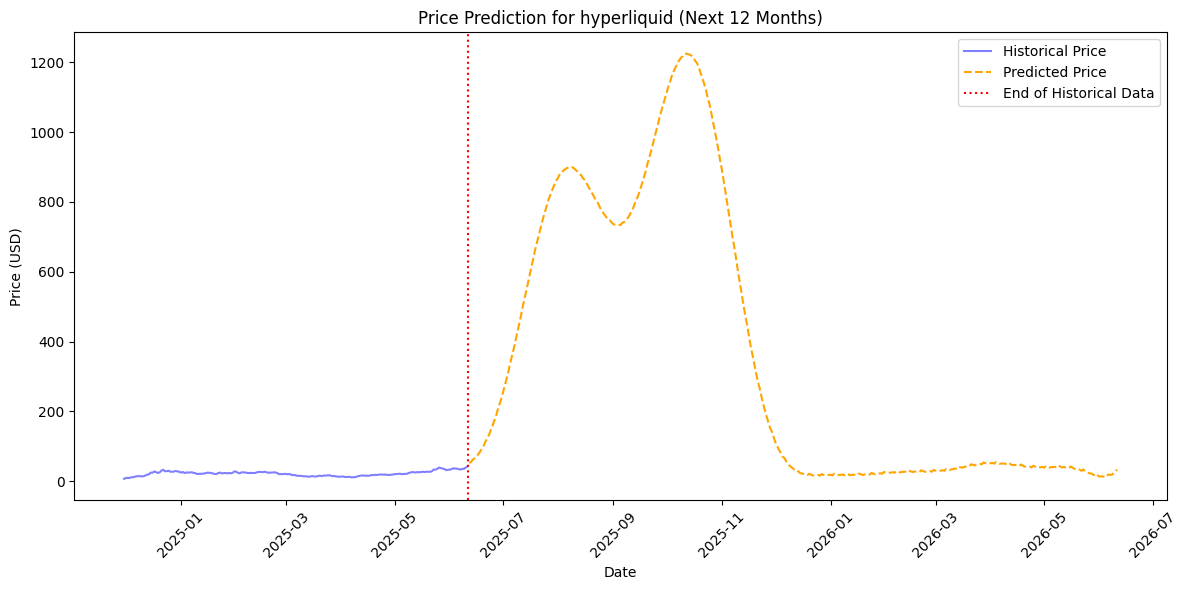

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for leo-token...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for leo-token:      train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
0      0.457761       0.0  3.146812  3.950030  0.457550      0.0      0
1      0.194840       0.0  1.728860  2.133445  0.194467      0.0      1
2      0.066230       0.0  0.858555  1.140817  0.066285      0.0      2
3      0.036754       0.0  0.594706  0.763052  0.036468      0.0      3
4      0.016159       0.0  0.379654  0.483990  0.016047      0.0      4
..          ...       ...       ...       ...       ...      ...    ...
155    0.001800       0.0  0.108381  0.154301  0.001786      0.0    155
156    0.001818       0.0  0.109459  0.154187  0.001812      0.0    156
157    0.001808       0.0  0.108568  0.153681  0.001797      0.0    157
158    0.001800       0.0  0.108470  0.153910  0.001803      0.0    158
159    0.001806       0.0  0.108130  0.149715  0.001786      0.0    159

[160 rows x 7 columns]
Last historical date for leo-token: 2025-06-11 00:00:00
Combined dataframe columns 

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for leo-token: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


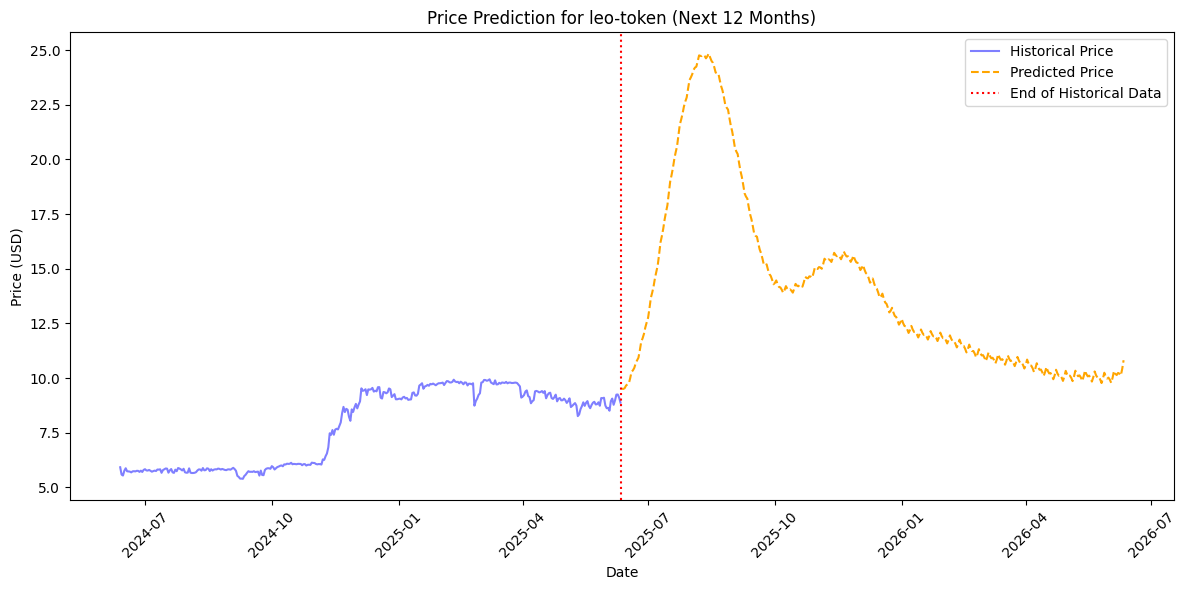

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for ripple...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for ripple:      train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
0      1.345221       0.0  4.701477  5.750152  1.341346      0.0      0
1      0.661363       0.0  2.624164  3.458996  0.656891      0.0      1
2      0.358209       0.0  1.654135  2.164343  0.357443      0.0      2
3      0.222430       0.0  1.142247  1.492103  0.221395      0.0      3
4      0.110475       0.0  0.677944  0.948200  0.110451      0.0      4
..          ...       ...       ...       ...       ...      ...    ...
155    0.002640       0.0  0.068688  0.100770  0.002776      0.0    155
156    0.002648       0.0  0.069207  0.101453  0.002660      0.0    156
157    0.002655       0.0  0.068783  0.100398  0.002646      0.0    157
158    0.002629       0.0  0.068309  0.097960  0.002621      0.0    158
159    0.002644       0.0  0.069212  0.101770  0.002650      0.0    159

[160 rows x 7 columns]
Last historical date for ripple: 2025-06-11 00:00:00
Combined dataframe columns for ri

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for ripple: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


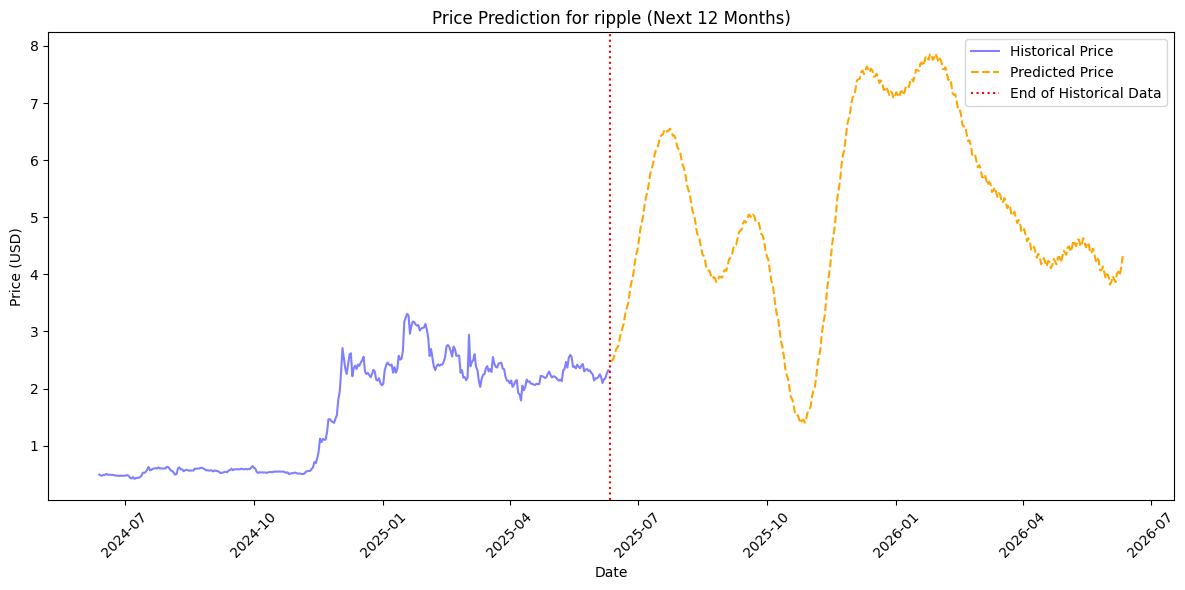

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for solana...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for solana:      train_loss  reg_loss         MAE        RMSE      Loss  RegLoss  epoch
0      0.781000       0.0  148.938110  175.526901  0.777200      0.0      0
1      0.342051       0.0   76.003220   92.756187  0.341493      0.0      1
2      0.163897       0.0   44.767677   56.083439  0.162796      0.0      2
3      0.073801       0.0   27.709274   33.684376  0.073615      0.0      3
4      0.030556       0.0   16.783100   20.585192  0.030423      0.0      4
..          ...       ...         ...         ...       ...      ...    ...
155    0.005149       0.0    6.565487    8.211020  0.005109      0.0    155
156    0.005153       0.0    6.574522    8.287070  0.005134      0.0    156
157    0.005132       0.0    6.559018    8.254727  0.005110      0.0    157
158    0.005120       0.0    6.561596    8.229867  0.005098      0.0    158
159    0.005147       0.0    6.613817    8.388207  0.005276      0.0    159

[160 rows x 7 columns]
Last historical date for solana: 2025-

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for solana: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


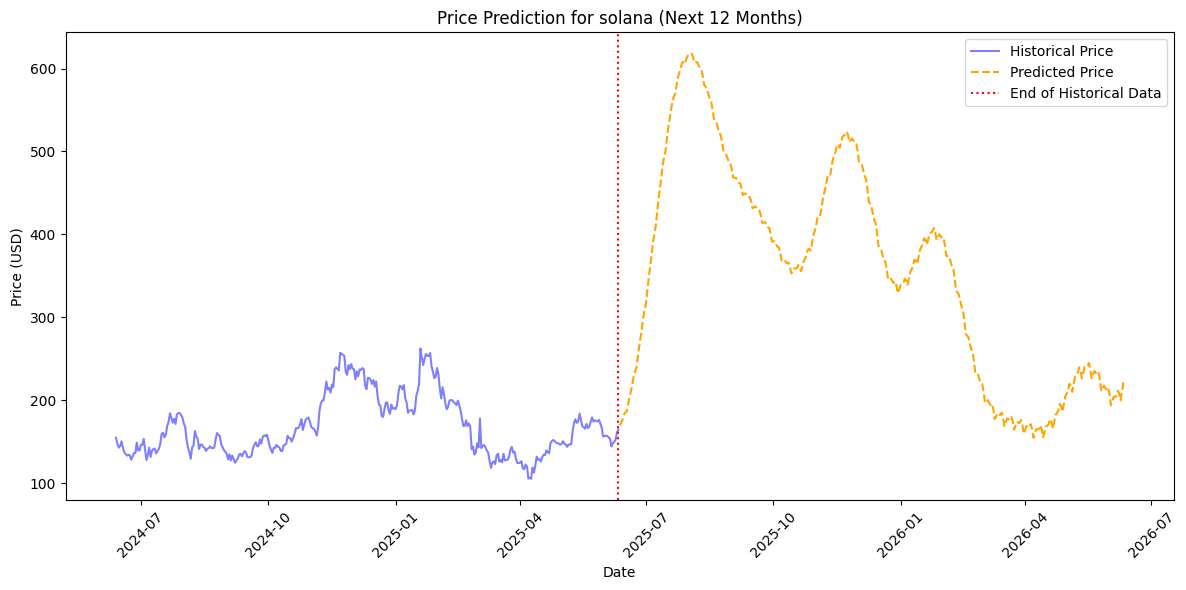

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for staked-ether...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for staked-ether:      train_loss  reg_loss          MAE         RMSE      Loss  RegLoss  epoch
0      0.795356       0.0  2805.688232  3221.696045  0.792436      0.0      0
1      0.499570       0.0  1933.473145  2329.557373  0.498355      0.0      1
2      0.304395       0.0  1348.169556  1743.575806  0.303781      0.0      2
3      0.187504       0.0   967.552917  1389.437378  0.186487      0.0      3
4      0.146279       0.0   807.247131  1205.535400  0.147071      0.0      4
..          ...       ...          ...          ...       ...      ...    ...
155    0.003201       0.0    84.893341   107.606636  0.003187      0.0    155
156    0.003202       0.0    85.496346   108.545166  0.003253      0.0    156
157    0.003198       0.0    84.989868   107.322723  0.003190      0.0    157
158    0.003210       0.0    85.320702   107.876274  0.003221      0.0    158
159    0.003189       0.0    84.535027   106.777916  0.003168      0.0    159

[160 rows x 7 columns]
Last his

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for staked-ether: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


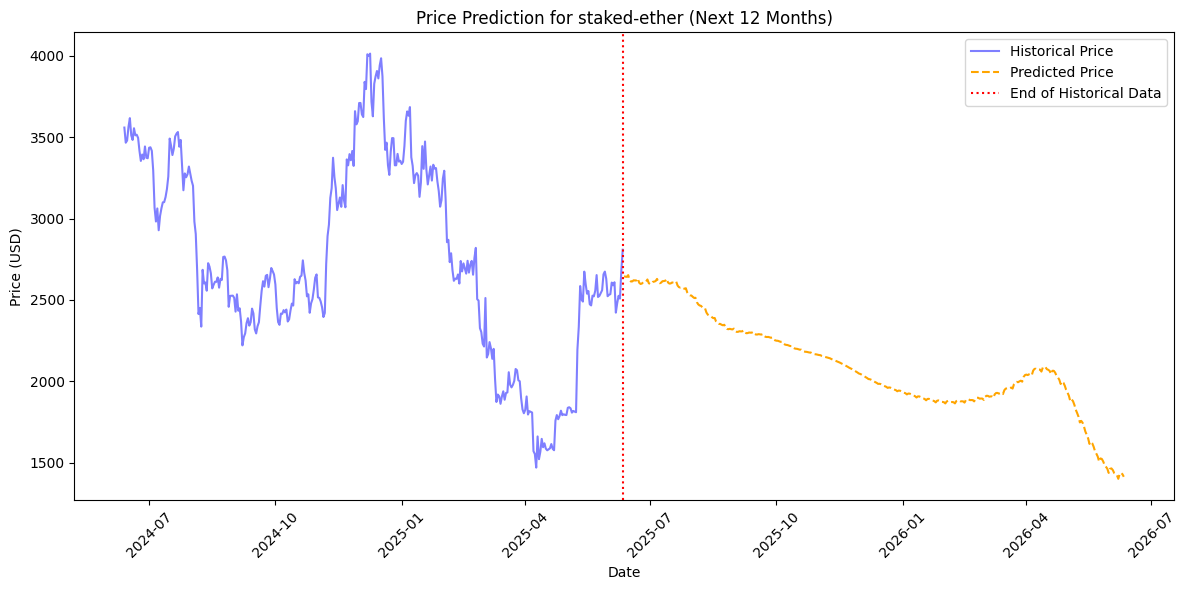

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for stellar...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for stellar:      train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
0      0.540377       0.0  0.287269  0.382690  0.539214      0.0      0
1      0.184783       0.0  0.138686  0.165737  0.185255      0.0      1
2      0.202359       0.0  0.154534  0.179459  0.201951      0.0      2
3      0.084020       0.0  0.089548  0.106123  0.083326      0.0      3
4      0.030772       0.0  0.049248  0.061748  0.030458      0.0      4
..          ...       ...       ...       ...       ...      ...    ...
155    0.003303       0.0  0.011172  0.017575  0.003290      0.0    155
156    0.003294       0.0  0.011157  0.017547  0.003282      0.0    156
157    0.003295       0.0  0.010994  0.017212  0.003257      0.0    157
158    0.003367       0.0  0.011301  0.017523  0.003335      0.0    158
159    0.003353       0.0  0.011093  0.017199  0.003316      0.0    159

[160 rows x 7 columns]
Last historical date for stellar: 2025-06-11 00:00:00
Combined dataframe columns for 

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for stellar: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


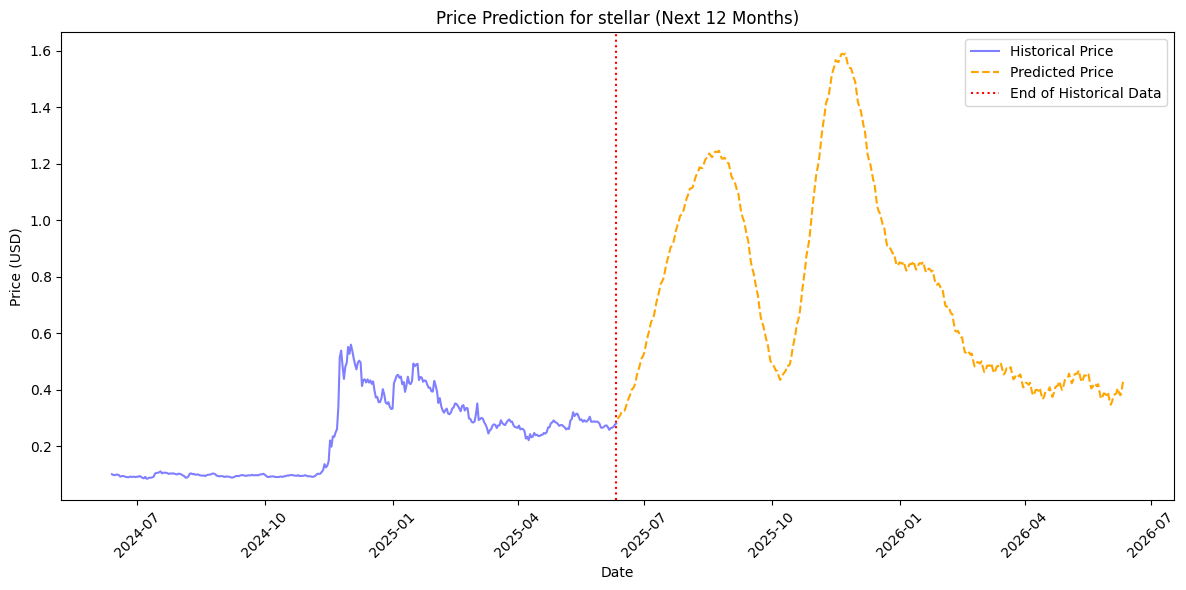

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for sui...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for sui:      train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
0      0.173868       0.0  1.556596  2.035139  0.172692      0.0      0
1      0.065138       0.0  0.803242  1.092241  0.064469      0.0      1
2      0.019356       0.0  0.394513  0.544875  0.019174      0.0      2
3      0.007719       0.0  0.250982  0.321041  0.007696      0.0      3
4      0.005137       0.0  0.197828  0.251619  0.005132      0.0      4
..          ...       ...       ...       ...       ...      ...    ...
155    0.002667       0.0  0.135150  0.177600  0.002667      0.0    155
156    0.002679       0.0  0.135103  0.178436  0.002702      0.0    156
157    0.002668       0.0  0.136184  0.179228  0.002705      0.0    157
158    0.002670       0.0  0.136114  0.179381  0.002680      0.0    158
159    0.002677       0.0  0.135612  0.177708  0.002678      0.0    159

[160 rows x 7 columns]
Last historical date for sui: 2025-06-11 00:00:00
Combined dataframe columns for sui: ['d

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for sui: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


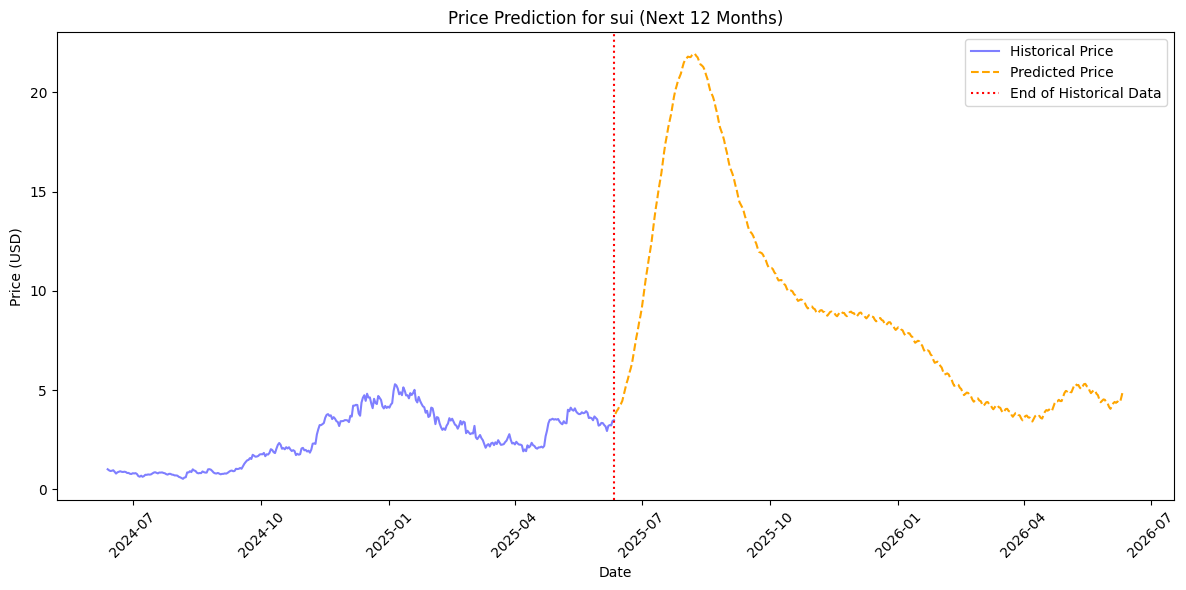

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for tether...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for tether:      train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
0      0.349572       0.0  0.002169  0.002669  0.348724      0.0      0
1      0.235924       0.0  0.001569  0.001877  0.234250      0.0      1
2      0.073815       0.0  0.000724  0.000931  0.073261      0.0      2
3      0.035945       0.0  0.000490  0.000630  0.035632      0.0      3
4      0.036254       0.0  0.000490  0.000624  0.036169      0.0      4
..          ...       ...       ...       ...       ...      ...    ...
155    0.025270       0.0  0.000380  0.000527  0.025440      0.0    155
156    0.025305       0.0  0.000377  0.000523  0.025060      0.0    156
157    0.025266       0.0  0.000378  0.000528  0.025165      0.0    157
158    0.025274       0.0  0.000381  0.000519  0.025358      0.0    158
159    0.025240       0.0  0.000378  0.000524  0.025069      0.0    159

[160 rows x 7 columns]
Last historical date for tether: 2025-06-11 00:00:00
Combined dataframe columns for te

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for tether: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


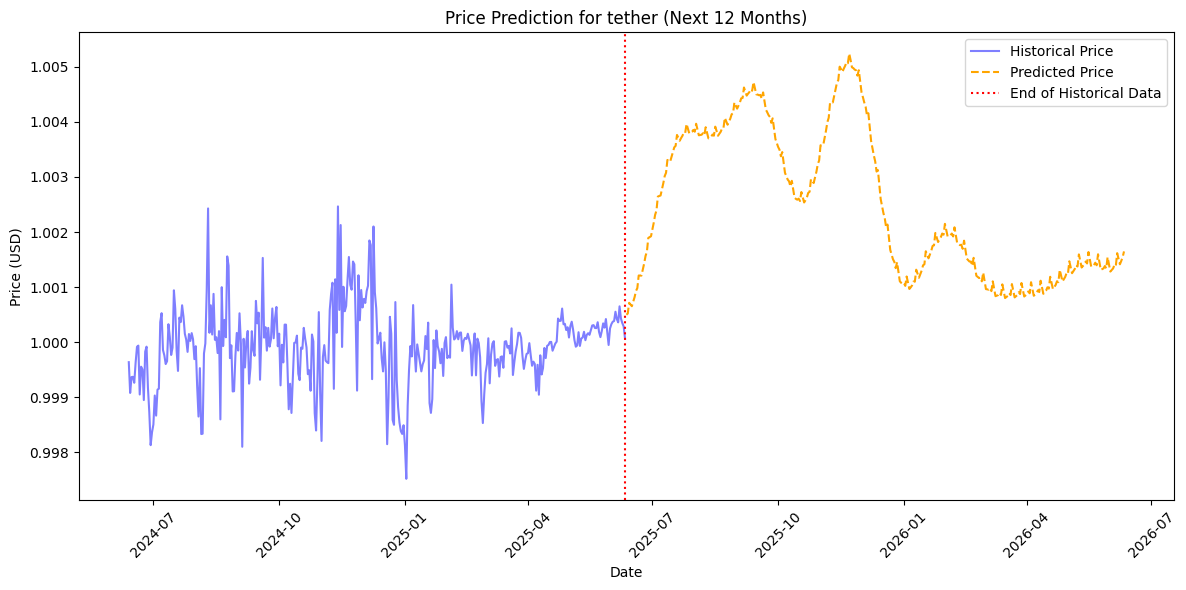

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for tron...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for tron:      train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
0      1.137288       0.0  0.258183  0.288185  1.135408      0.0      0
1      0.514278       0.0  0.136136  0.153114  0.510499      0.0      1
2      0.167331       0.0  0.058808  0.075514  0.166259      0.0      2
3      0.164645       0.0  0.053218  0.069210  0.163990      0.0      3
4      0.081892       0.0  0.037810  0.048591  0.081613      0.0      4
..          ...       ...       ...       ...       ...      ...    ...
155    0.005309       0.0  0.005536  0.009141  0.005251      0.0    155
156    0.005305       0.0  0.005559  0.009397  0.005280      0.0    156
157    0.005302       0.0  0.005472  0.009129  0.005247      0.0    157
158    0.005302       0.0  0.005609  0.009481  0.005621      0.0    158
159    0.005286       0.0  0.005469  0.009309  0.005229      0.0    159

[160 rows x 7 columns]
Last historical date for tron: 2025-06-11 00:00:00
Combined dataframe columns for tron: 

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for tron: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


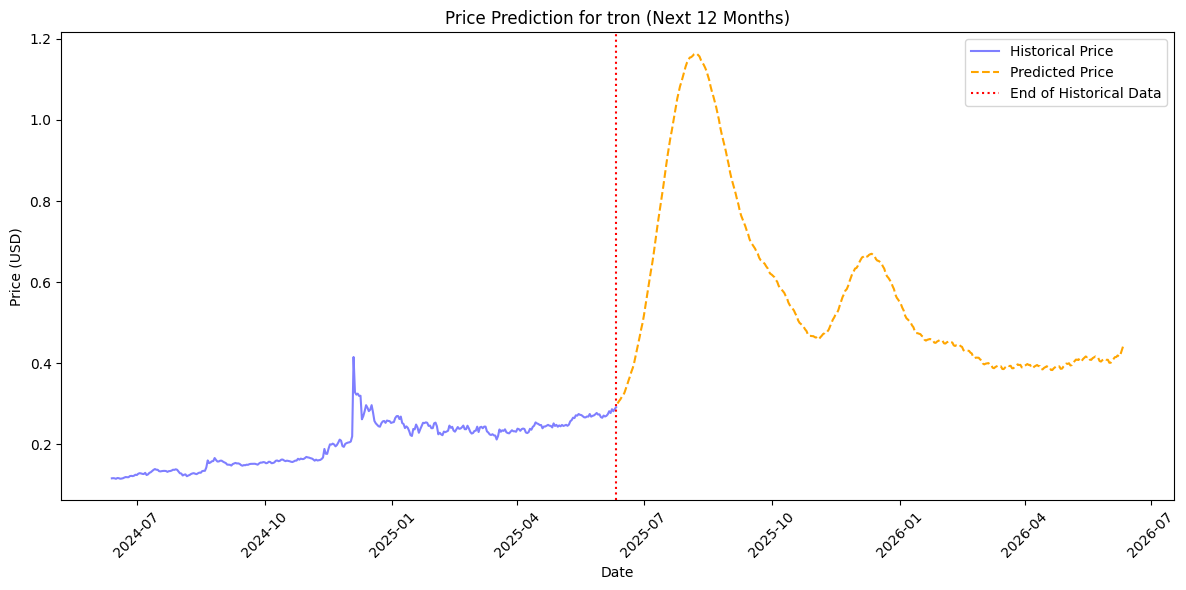

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for usd-coin...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for usd-coin:      train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
0      2.092030       0.0  0.009539  0.010090  2.090994      0.0      0
1      1.483294       0.0  0.007021  0.007374  1.479527      0.0      1
2      0.900994       0.0  0.004515  0.004736  0.895703      0.0      2
3      0.429535       0.0  0.002367  0.002700  0.427208      0.0      3
4      0.274255       0.0  0.001565  0.001930  0.274232      0.0      4
..          ...       ...       ...       ...       ...      ...    ...
155    0.016620       0.0  0.000243  0.000401  0.016724      0.0    155
156    0.016608       0.0  0.000243  0.000398  0.016496      0.0    156
157    0.016595       0.0  0.000243  0.000395  0.016505      0.0    157
158    0.016631       0.0  0.000243  0.000410  0.016504      0.0    158
159    0.016613       0.0  0.000241  0.000401  0.016428      0.0    159

[160 rows x 7 columns]
Last historical date for usd-coin: 2025-06-11 00:00:00
Combined dataframe columns fo

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for usd-coin: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


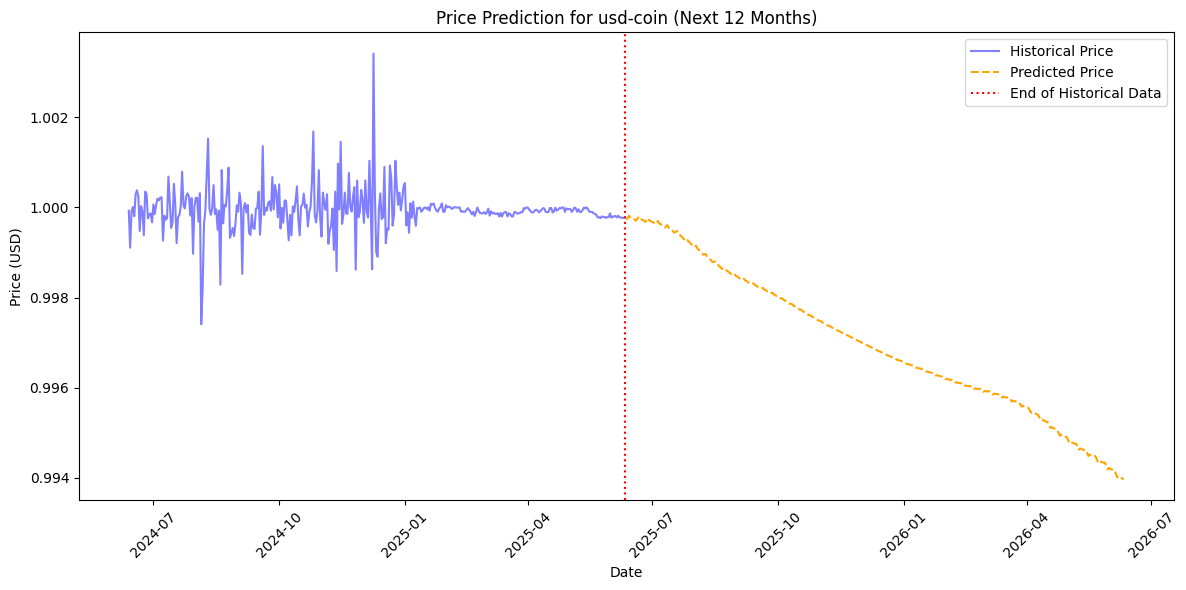

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for wrapped-bitcoin...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for wrapped-bitcoin:      train_loss  reg_loss            MAE           RMSE      Loss  RegLoss  \
0      1.458877       0.0  106245.937500  112924.000000  1.460172      0.0   
1      0.904270       0.0   71047.140625   75428.304688  0.900019      0.0   
2      0.380300       0.0   36719.816406   41576.351562  0.378709      0.0   
3      0.185509       0.0   19997.720703   25300.113281  0.186244      0.0   
4      0.149474       0.0   16607.632812   20842.130859  0.148291      0.0   
..          ...       ...            ...            ...       ...      ...   
155    0.002600       0.0    1820.329468    2283.166748  0.002619      0.0   
156    0.002604       0.0    1821.315674    2299.516113  0.002603      0.0   
157    0.002603       0.0    1813.522461    2276.284912  0.002630      0.0   
158    0.002586       0.0    1803.849365    2284.035156  0.002579      0.0   
159    0.002584       0.0    1817.057251    2292.636475  0.002613      0.0   

     epoch  
0        0  
1 

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for wrapped-bitcoin: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


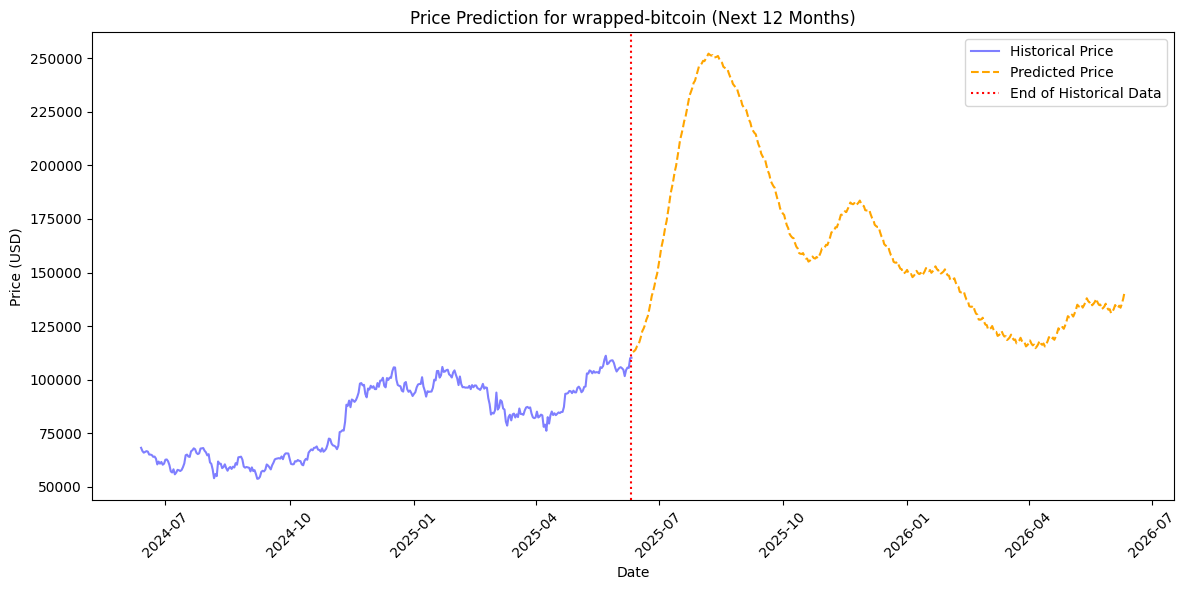

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ne

Training model for wrapped-steth...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\ghane\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Model metrics for wrapped-steth:      train_loss  reg_loss          MAE         RMSE      Loss  RegLoss  epoch
0      1.254750       0.0  4642.287598  5629.917480  1.248185      0.0      0
1      0.642574       0.0  2645.788818  3361.042725  0.638507      0.0      1
2      0.227316       0.0  1207.559692  1707.635010  0.226556      0.0      2
3      0.137321       0.0   810.646118  1080.678223  0.136955      0.0      3
4      0.068876       0.0   526.309570   726.377808  0.068582      0.0      4
..          ...       ...          ...          ...       ...      ...    ...
155    0.003437       0.0   105.110832   131.929718  0.003433      0.0    155
156    0.003481       0.0   105.169670   133.343430  0.003483      0.0    156
157    0.003418       0.0   104.560013   131.140076  0.003407      0.0    157
158    0.003449       0.0   105.331459   132.301376  0.003440      0.0    158
159    0.003429       0.0   104.956139   131.426880  0.003432      0.0    159

[160 rows x 7 columns]
Last hi

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Forecast date range for wrapped-steth: 2025-06-12 00:00:00 to 2026-06-11 00:00:00


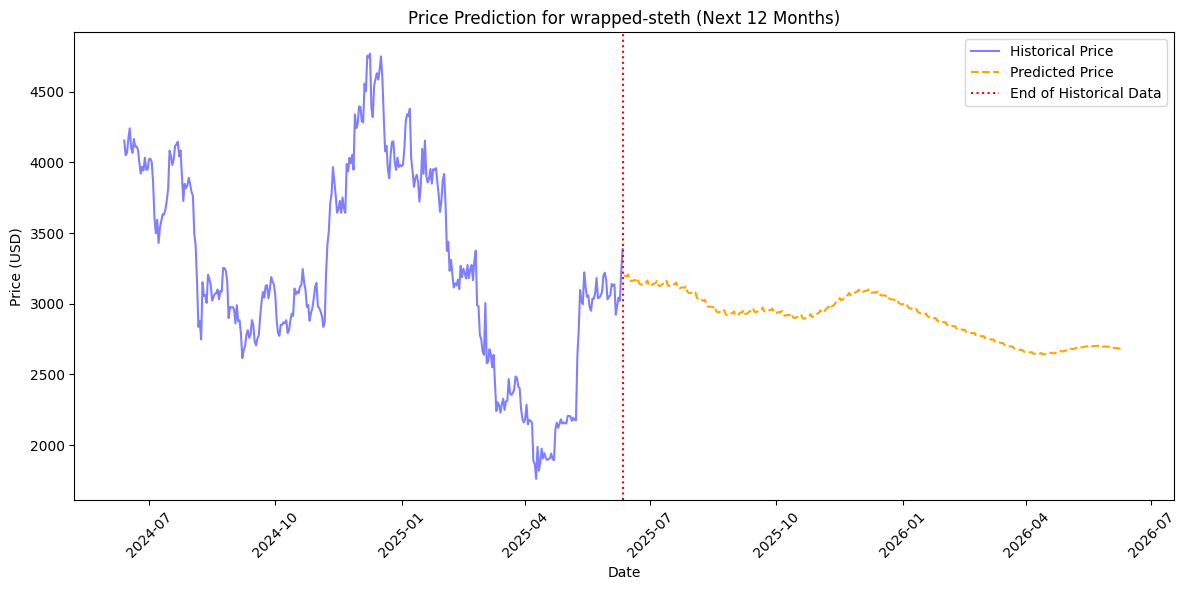

In [19]:
# Model Training and Prediction for 12 months (365 days)
for coin_id, coin_df in coin_dfs.items():
    print(f"Training model for {coin_id}...")
    model = NeuralProphet(
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        learning_rate=0.1,
        n_changepoints=50
    )
    model.add_lagged_regressor(names='y_lag1')
    model.add_lagged_regressor(names='y_rolling_mean7')

    # Fit the model with all required columns
    metrics = model.fit(coin_df, freq='D')
    print(f"Model metrics for {coin_id}: {metrics}")

    # Get the last historical date and verify data
    last_historical_date = coin_df['ds'].max()
    print(f"Last historical date for {coin_id}: {last_historical_date}")
    if coin_df.empty or coin_df['y'].isnull().all():
        print(f"Warning: No valid data for {coin_id}. Skipping prediction.")
        continue

    # Create future dataframe starting right after the last historical date
    future_dates = pd.date_range(start=last_historical_date + timedelta(days=1), periods=365, freq='D')
    future_df = pd.DataFrame({'ds': future_dates, 'y': float('nan'), 'y_lag1': float('nan'), 'y_rolling_mean7': float('nan')})
    
    # Use the last known lagged values from historical data for future
    last_y_lag1 = coin_df['y_lag1'].iloc[-1] if not coin_df['y_lag1'].isna().all() else coin_df['y'].iloc[-1] if not coin_df['y'].isna().all() else 0
    last_y_rolling_mean7 = coin_df['y_rolling_mean7'].iloc[-1] if not coin_df['y_rolling_mean7'].isna().all() else coin_df['y'].rolling(window=7).mean().iloc[-1] if not coin_df['y'].isna().all() else 0
    future_df['y_lag1'] = last_y_lag1
    future_df['y_rolling_mean7'] = last_y_rolling_mean7

    # Combine historical and future data for prediction
    combined_df = pd.concat([coin_df, future_df], ignore_index=True)
    
    # Verify combined dataframe structure
    print(f"Combined dataframe columns for {coin_id}: {combined_df.columns.tolist()}")
    print(f"Number of rows in combined_df: {len(combined_df)}")
    print(f"Last historical date in combined_df: {combined_df['ds'].iloc[len(coin_df)-1]}")
    print(f"First future date in combined_df: {combined_df['ds'].iloc[len(coin_df)]}")

    # Predict using the combined dataframe
    try:
        forecast = model.predict(combined_df)
    except ValueError as e:
        print(f"Prediction error for {coin_id}: {e}")
        continue

    # Filter future predictions
    forecast_future = forecast[forecast['ds'] > last_historical_date]

    # Verify future dates
    if forecast_future.empty:
        print(f"Warning: No future predictions for {coin_id}. Check model or data.")
    else:
        print(f"Forecast date range for {coin_id}: {forecast_future['ds'].min()} to {forecast_future['ds'].max()}")

    # Plot forecast, showing only future predictions with historical context
    plt.figure(figsize=(12, 6))
    plt.plot(coin_df['ds'], coin_df['y'], label='Historical Price', alpha=0.5, color='blue')
    if not forecast_future.empty:
        plt.plot(forecast_future['ds'], forecast_future['yhat1'], label='Predicted Price', color='orange', linestyle='--')
    plt.axvline(x=last_historical_date, color='red', linestyle=':', label='End of Historical Data')
    plt.title(f'Price Prediction for {coin_id} (Next 12 Months)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Save forecast
    if not forecast_future.empty:
        forecast_future.to_csv(f'forecast_{coin_id}_12months.csv', index=False)
    else:
        print(f"No forecast saved for {coin_id} due to empty prediction.")

In [32]:
forecast_future.to_csv(f'forecast_{coin_id}_12months.csv', index=False)

In [21]:
for coin_id in coin_dfs.keys():
    model.save(f'model_{coin_id}.pkl')
    print(f"Model saved for {coin_id}.")

AttributeError: 'NeuralProphet' object has no attribute 'save'

In [22]:
model.save(f"models/{coin_id}_model.np")


AttributeError: 'NeuralProphet' object has no attribute 'save'

In [23]:
forecast_future.to_csv(f'forecast_{coin_id}_12months.csv', index=False)


In [24]:
# app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import os

st.set_page_config(page_title="Crypto Forecast", layout="wide")
st.title("📊 NeuralProphet Crypto Forecast Viewer")

# Get list of available forecast CSVs
forecast_files = [f for f in os.listdir("forecasts") if f.endswith(".csv")]

if not forecast_files:
    st.warning("No forecast files found in the 'forecasts' directory.")
    st.stop()

# Coin selection
coin_ids = [f.replace("forecast_", "").replace("_12months.csv", "") for f in forecast_files]
coin_id = st.selectbox("Select a cryptocurrency:", coin_ids)

# Load forecast
forecast_path = f"forecasts/forecast_{coin_id}_12months.csv"
df = pd.read_csv(forecast_path)
df['ds'] = pd.to_datetime(df['ds'])

# Plot
st.subheader(f"📈 Forecast for {coin_id} (Next 12 Months)")
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['ds'], df['yhat1'], color='orange', label="Predicted Price")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.set_title(f"{coin_id} Price Forecast")
ax.legend()
st.pyplot(fig)

# Optional: Show Data Table
with st.expander("📄 Show Forecast Data Table"):
    st.dataframe(df[['ds', 'yhat1']].rename(columns={"ds": "Date", "yhat1": "Predicted Price"}))


2025-06-11 15:17:54.415 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 15:17:54.416 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 15:17:54.682 
  command:

    streamlit run C:\Users\ghane\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-11 15:17:54.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'forecasts'

In [25]:
!pip install streamlit neuralprophet matplotlib pyngrok


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
%%writefile app.py
import streamlit as st
from neuralprophet import NeuralProphet
import pandas as pd
import matplotlib.pyplot as plt

# Title of the app
st.title("Crypto Price Prediction App")

# Sidebar to select coin
coin_options = ['chainlink', 'dogecoin']  # Adjust based on your coins
selected_coin = st.sidebar.selectbox("Select Coin", coin_options)

# Load the saved model
model = NeuralProphet.load(f'model_{selected_coin}.pkl')

# Load historical and forecast data
forecast_df = pd.read_csv(f'forecast_{selected_coin}_12months.csv')
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
historical_df = forecast_df[forecast_df['y'].notna()]  # Historical data where y is not NaN
forecast_future = forecast_df[forecast_df['ds'] > historical_df['ds'].max()]  # Future predictions

# Plot the data
st.subheader(f"Price Prediction for {selected_coin} (Next 12 Months)")
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(historical_df['ds'], historical_df['y'], label='Historical Price', alpha=0.5, color='blue')
ax.plot(forecast_future['ds'], forecast_future['yhat1'], label='Predicted Price', color='orange', linestyle='--')
last_historical_date = historical_df['ds'].max()
ax.axvline(x=last_historical_date, color='red', linestyle=':', label='End of Historical Data')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.legend()
ax.tick_params(axis='x', rotation=45)
st.pyplot(fig)

Writing app.py


In [30]:
!pip install streamlit pyngrok --quiet

from pyngrok import ngrok

# Set your ngrok auth token
ngrok.set_auth_token("2uAow1q0FZhHYoG2CKVocQImM0v_37MHhReq4zXJEhmzgSZ5F")


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


PyngrokNgrokInstallError: An error occurred while downloading ngrok from https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-windows-amd64.zip: [Errno 22] Invalid argument: 'C:\\Users\\ghane\\AppData\\Local\\Temp\\ngrok-v3-stable-windows-amd64.zip'

In [31]:
import joblib
joblib.dump(model, f"{coin_id}_neuralprophet_model.pkl")


['avalanche-2_neuralprophet_model.pkl']